<a href="https://colab.research.google.com/github/vjcitn/HumanTranscriptomeCompendium/blob/master/Copy_of_HTXoverview2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using the HumanTranscriptomeCompendium with Bioconductor

HumanTranscriptomeCompendium refers to a cloud-resident collection of uniformly produced quantifications for 181000 RNA-seq experiments derived from NCBI SRA in Summer 2017.  The quantifications were obtained by Dr. Sean Davis of NCI using [salmon](https://combine-lab.github.io/salmon/) and transformed to HDF5 by Dr. VJ Carey of Harvard Medical School.  The data are available in the HDF Scalable Data Service (HSDS) thanks to the support of John Readey of the HDF Group.  In this very brief introductory document we illustrate how to access the data and related annotations.

1. [Setup](#setup)
2. [Metadata management and interrogation](#metadata)
   1. [DocSet: indexed metadata](#docset)
   2. [Querying a DocSet](#querdoc)
3. [Filtering the compendium](#filtering)
   1. [Metadata overview](#overview)
   2. [Drilling down to tabulate study design factors](#drill)
4. [Statistical characteristics of the compendium](#stat)
   1. [Distribution of study sizes](#sizes)
   2. [Availability of gender or ethnicity information](#geneth)
   3. [Single-gene surveys](#sing)
5. [Summary](#summary)

## Setup and initial acquaintance  <a id="setup"></a>

As of April 1 2019, we need to retrieve key packages from github.

In [1]:
if (!file.exists("Bioc_3.10_colab_htxpkgs.zip")) system("gsutil cp gs://bioc_pkgs_aug_2019/Bioc_3.10_colab_htxpkgs.zip .", intern=TRUE)

character(0)

In [2]:
if (!dir.exists("Bioc3.10_colab_htxpkgs")) system("unzip Bioc_3.10_colab_htxpkgs.zip"); dir()

[1] "Bioc_3.10_colab_htxpkgs.zip" "Bioc3.10_colab_htxpkgs"     
[3] "sample_data"

In [0]:
.libPaths(c("Bioc3.10_colab_htxpkgs", .libPaths()))

In [4]:
ii = installed.packages()
dim(ii)

[1] 194  16

In [5]:
library(HumanTranscriptomeCompendium)
se1 = addRD(htx_load())
se1

Loading required namespace: BiocFileCache

Using temporary cache /tmp/Rtmp4SDJAD/BiocFileCache

adding RDS to local cache, future invocations will use local image

adding rname 'https://s3.amazonaws.com/bcfound-bigrna/rangedHtxGeneSE.rds'



class: RangedSummarizedExperiment 
dim: 58288 181134 
metadata(1): rangeSource
assays(1): counts
rownames(58288): ENSG00000000003.14 ENSG00000000005.5 ...
  ENSG00000284747.1 ENSG00000284748.1
rowData names(4): gene_type gene_id gene_name havana_gene
colnames(181134): DRX001125 DRX001126 ... SRX999990 SRX999991
colData names(4): experiment_accession experiment_platform
  study_accession study_title

This SummarizedExperiment instance is developed according to methods defined in the [restfulSE package](https://bioconductor.org/packages/restfulSE/).  See the related [f1000research report](https://f1000research.com/articles/8-21/v1).

The `assay` method involves the [DelayedArray](https://bioconductor.org/packages/DelayedArray/) protocol.  A preview of remote numerical data is provided when `assay` is invoked.  Note that very large requests of data through the `as.matrix` method on a DelayedArray in HSDS will likely engender errors.

In [27]:
suppressPackageStartupMessages(library(SummarizedExperiment))
options(digits=4)
assay(se1)

<58288 x 181134> matrix of class DelayedMatrix and type "double":
                   DRX001125 DRX001126 DRX001127 ... SRX999990 SRX999991
ENSG00000000003.14     40.00   1322.84   1528.26   .    1149.0    1430.4
 ENSG00000000005.5      0.00     10.00      6.00   .       0.0       0.0
ENSG00000000419.12     64.00   1456.00   2039.00   .    1485.0    1970.0
ENSG00000000457.13     31.81   1583.50   1715.04   .     631.8     802.1
ENSG00000000460.16     12.43    439.32    529.28   .     945.7    1259.8
               ...         .         .         .   .         .         .
 ENSG00000284744.1 1.056e+00 2.481e+01 3.229e+01   .     7.316     3.268
 ENSG00000284745.1 1.000e+00 1.600e+01 1.700e+01   .     0.000     0.000
 ENSG00000284746.1 0.000e+00 3.795e-03 0.000e+00   .     0.000     0.000
 ENSG00000284747.1 7.776e+00 2.708e+02 2.399e+02   .   108.012    94.607
 ENSG00000284748.1 1.000e+00 2.223e+01 3.774e+01   .    11.279     5.241

## Metadata management and interrogation <a id="metadata"></a>

The [ssrch](https://github.com/vjcitn/ssrch) package (pending at Bioconductor) defines utilities for managing heterogeneous metadata.  A snapshot of metadata available in March 2019 was obtained using the [SRAdbV2](https://github.com/seandavi/SRAdbV2) package of Sean Davis of NCI.  The `sample.attribute` information was indexed and organized into a `DocSet` instance as defined in `ssrch`.

### DocSet: indexed metadata <a id="docset"/>

The HumanTranscriptomeCompendium package has sample attribute data.frame instances for 4841 studies available in NCBI SRA.

In [7]:
library(ssrch)
ds4841 = HumanTranscriptomeCompendium::get_ds4841()

Using temporary cache /tmp/Rtmp4SDJAD/BiocFileCache

one time retrieval for https://s3.amazonaws.com/bcfound-bigrna/ds4841.rda

adding rname 'https://s3.amazonaws.com/bcfound-bigrna/ds4841.rda'

Using temporary cache /tmp/Rtmp4SDJAD/BiocFileCache

one time retrieval for https://s3.amazonaws.com/bcfound-bigrna/doc4842.zip

adding rname 'https://s3.amazonaws.com/bcfound-bigrna/doc4842.zip'



### Querying a DocSet <a id="querdoc"/>

The `searchDocs` function can obtain study accession numbers for studies that employ terms of interest.  In the following we check for studies using the regexp `BRAF[- ]mut`.

In [8]:
brm = searchDocs("BRAF[- ]mut", ds4841)
brm

hits,docs
<chr>,<chr>
BRAF mutation,SRP080797
BRAF-mut,SRP027530
BRAF-mutant,SRP065849


## Filtering the compendium <a id="filtering"/>

Given a vector of study accession numbers, we filter the compendium (in a delayed manner):

In [9]:
se_brafmut = htx_query_by_study_accession(brm$docs, se1)
se_brafmut

Using temporary cache /tmp/Rtmp4SDJAD/BiocFileCache

Using temporary cache /tmp/Rtmp4SDJAD/BiocFileCache



class: RangedSummarizedExperiment 
dim: 58288 72 
metadata(4): rangeSource SRP080797 SRP027530 SRP065849
assays(1): counts
rownames(58288): ENSG00000000003.14 ENSG00000000005.5 ...
  ENSG00000284747.1 ENSG00000284748.1
rowData names(4): gene_type gene_id gene_name havana_gene
colnames(72): SRX1420823 SRX1420824 ... SRX3241750 SRX3241751
colData names(4): experiment_accession experiment_platform
  study_accession study_title

### Metadata overview <a id="overview"></a>
    
We obtained a collection of 72 samples.  The sample-level metadata are heterogeneous, possessing unique field sets and informal field annotations.

In [10]:
lapply(metadata(se_brafmut)[-1], head, 3)

$SRP080797
           X study.accession experiment.accession source_name cell.line
SRX1994764 2       SRP080797           SRX1994764        Skin      A375
SRX1994763 3       SRP080797           SRX1994763        Lung      A549
SRX1994775 4       SRP080797           SRX1994775        Skin      A375
           genetic.background                                    culture.medium
SRX1994764      BRAF mutation Starvation: Culture in 0.5% FBS medium for 2 days
SRX1994763      KRAS mutation Starvation: Culture in 0.5% FBS medium for 2 days
SRX1994775      BRAF mutation Starvation: Culture in 0.5% FBS medium for 2 days
                                       agent                   egf.stimulation
SRX1994764        DMSO treatment for 3 hours                              <NA>
SRX1994763   MEK inhibitor 3 hours at 0.2 uM EGF stimulation: 20 min, 100ng/ml
SRX1994775 INTS11 siRNA transfection, 3 days EGF stimulation: 20 min, 100ng/ml

$SRP027530
          X study.accession experiment.accession   source_name         tissue
SRX323589 1       SRP027530            SRX323589 Thyroid tumor Thyroid cancer
SRX323603 2       SRP027530            SRX323603 Thyroid tumor Thyroid cancer
SRX323599 3       SRP027530            SRX323599 Thyroid tumor Thyroid cancer
          age    Sex tumor.stage genotype.variation
SRX323589  57 female     T1bN0M0           BRAF-mut
SRX323603  57 female     T1bN0M0           BRAF-mut
SRX323599  44 female    T1bN1aM0            BRAF-wt

$SRP065849
           X study.accession experiment.accession                 source_name
SRX1420824 1       SRP065849           SRX1420824 A375 melanoma bearing mouse
SRX1420825 2       SRP065849           SRX1420825 A375 melanoma bearing mouse
SRX1420826 3       SRP065849           SRX1420826 A375 melanoma bearing mouse
               tissue             phenotype host.mouse.treatment
SRX1420824 A375 tumor vemurafenib-sensitive                 none
SRX1420825 A375 tumor vemurafenib-sensitive                 none
SRX1420826 A375 tumor vemurafenib-sensitive                 none

For the first two studies the role played by BRAF is clear.  However, the table for SRP065849 does not seem to use the token `BRAF` in any field.  It turns out that BRAF is used in the study title, and titles were harvested for the metadata index.

In [11]:
slot(ds4841, "titles")["SRP065849"]

SRP065849 
"A novel RAF kinase inhibitor with DFG-out binding mode: high efficacy in BRAF-mutant tumor xenograft models in the absence of normal tissue hyperproliferation"

### Drilling down to tabulate study design factors <a id="drill"></a>

We will crosstabulate the key factors from SRP080797, derived from a 2017 Genes and Development paper entitled 'Integrator orchestrates RAS/ERK1/2 signaling transcriptional programs'.  Note the inconsistent notation for the MEK inhibitor factor, leading to an unnecessary stratum.

In [12]:
md = metadata(se_brafmut)[-1]
with(md$SRP080797, xtabs(~agent+cell.line+genetic.background))

, , genetic.background = BRAF mutation

                                    cell.line
agent                                A375 A549 HeLa
  BRAF inhibitor 3 hours at 1uM         2    0    0
  Control siRNA transfection, 3 days    2    0    0
  DMSO treatment for 3 hours            2    0    0
  Doxycycline for 3 days                0    0    0
  ERK inhibitor 3 hours at 1uM          1    0    0
  INTS11 siRNA transfection, 3 days     2    0    0
  MEK inhibitor 3 hours at 0.2 uM       2    0    0
  MEK inhibitor for 3 hours at 0.2uM    0    0    0

, , genetic.background = Harboring inducible shRNA expressing cassette

                                    cell.line
agent                                A375 A549 HeLa
  BRAF inhibitor 3 hours at 1uM         0    0    0
  Control siRNA transfection, 3 days    0    0    0
  DMSO treatment for 3 hours            0    0    1
  Doxycycline for 3 days                0    0   14
  ERK inhibitor 3 hours at 1uM          0    0    2
  INTS11 siRNA 

## Statistical characteristics of the compendium <a id="stat"></a>

### Distribution of study sizes <a id="sizes"></a>

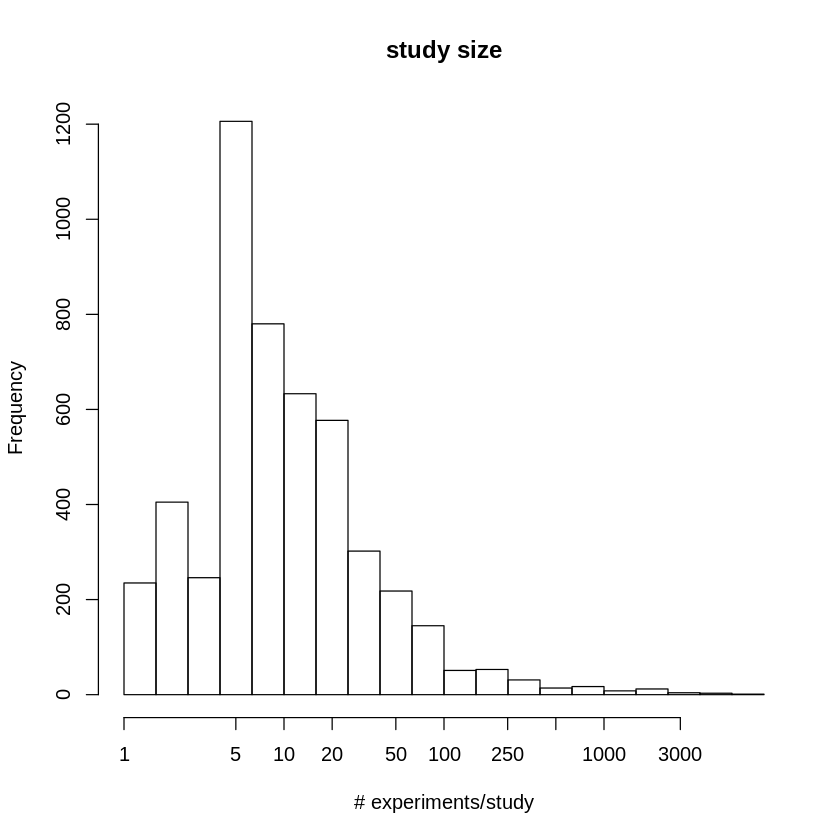

In [13]:
sizes = table(se1$study_accession)
hist(log10(sizes), 20, axes=FALSE, main="study size", xlab="# experiments/study")
axis(1, at=c(0, 0.699, 1, 1.301, 1.699, 2, 2.3979, 2.699, 3, 3.4771), 
     labels=c(1, 5, 10, 20, 50, 100, 250, 500, 1000, 3000))
axis(2)

Studies with at least 1000 experiments:

In [14]:
bigstud = which(sizes>=1000)
bigstud = bigstud[order(sizes[bigstud])]
data.frame(N=as.numeric(sizes[bigstud]), title=slot(ds4841, "titles")[names(sizes)[bigstud]])

N,title
<dbl>,<fct>
1001,CSER: Exploring Precision Cancer Medicine for Sarcoma and Rare Cancers
1004,Single Cell Transcriptome Conservation in Cryopreserved Cells and Tissues
1153,single cell transcriptomic analyses of human pancreatic islets
1236,_Genetics_of_gene_expression_in_macrophage_immune_response_Open_access
1373,GxE and Complex Traits
1520,Single-cell RNA-seq reveal lineage formation and X-chromosome dosage compensation in human preimplantation embryos
1536,NA
1544,Homo sapiens Raw sequence reads
1594,RNA Sequencing of Single Human Islet Cells Reveals Type 2 Diabetes Genes


### Availability of gender or ethnicity information <a id="geneth"></a>

There is no guarantee that gender or ethnicity is recorded in the sample.attributes field.  But sometimes it is.

In [15]:
sex.recorded = searchDocs("[Ss]ex$", ds4841)
dim(sex.recorded)
table(sex.recorded$hits)

[1] 1010    2


    cell.sex    fetal.sex     host_sex     host.sex    mixed sex obsolete.sex 
           7            1            1            2            1            1 
 patient.sex          sex          Sex 
           2          846          149 

In [16]:
eth.recorded = searchDocs("[Rr]ace$|[Ee]thn", ds4841)
dim(eth.recorded)
table(eth.recorded$hits)

[1] 156   2


Chinese Han ethnicity                ethnic     ethnic.background 
                    2                     1                     1 
         ethnic.group          Ethnic.Group            Ethnically 
                    1                     1                     1 
            ethnicity             Ethnicity    maternal_ethnicity 
                   86                     2                     1 
         patient.race                  race                  Race 
                    1                    55                     2 
    subject.ethnicity                 trace 
                    1                     1 

In [0]:
loggapdh = log(as.numeric(assay(se1[which(rowData(se1)$gene_name=="GAPDH")[1],]))+1)

In [0]:
logbrca2 = log(as.numeric(assay(se1[which(rowData(se1)$gene_name=="BRCA2")[1],]))+1)

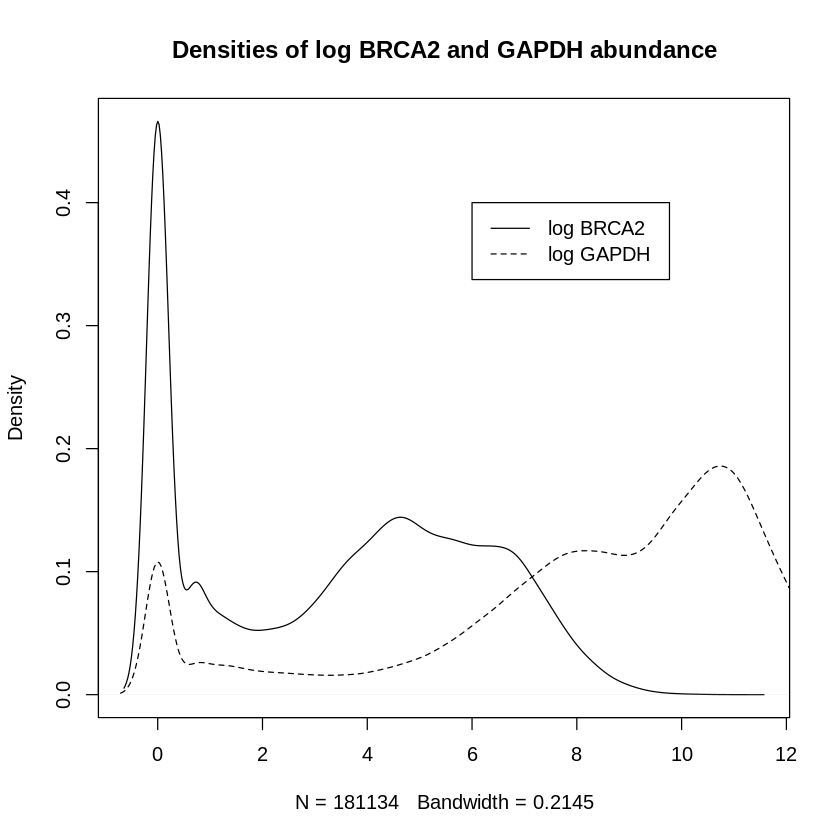

In [19]:
plot(density(logbrca2), main="Densities of log BRCA2 and GAPDH abundance")
lines(density(loggapdh), lty=2)
legend(6,.4, lty=c(1,2), legend=c("log BRCA2", "log GAPDH"))

## Summary <a id="summary"></a>

This notebook has demonstrated how one may interact directly with an image of 181000 uniformly preprocessed RNA-seq experiments.  Through the use of Bioconductor's SummarizedExperiment data structure and the restfulSE/DelayedArray protocols, the quantifications are tightly coupled with substantive metadata.  The use of HSDS to manage the quantifications is new, and methods for efficient extraction of large subsets for multivariate analysis are under development.

Comments regarding this work should be filed at the [HumanTranscriptomeCompendium](https://github.com/vjcitn/HumanTranscriptomeCompendium/issues) repository.  

This work was supported by grants from NIH NCI U01 CA214846, U24 CA180996, and Chan Zuckerberg Initiative DAF 2018-183436. 

In [20]:
sessionInfo()

R version 3.6.2 (2019-12-12)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ssrch_1.2.0                        rhdf5client_1.8.0                 
 [3] SummarizedExperiment_1.16.1        DelayedArray_0.12.2               
 [5] BiocParallel_1.20.1                matrixStats_0.55.0                
 [7] Biobase_2.46.0  

In [21]:
BiocManager::version()

[1] ‘3.10’

In [22]:
#system("mkdir Bioc3.10_colab_htxpkgs")
.libPaths()[1]
system("cp -r /usr/local/lib/R/site-library/* Bioc3.10_colab_htxpkgs")

[1] "/content/Bioc3.10_colab_htxpkgs"

In [0]:
system("zip -r Bioc_3.10_colab_htxpkgs.zip Bioc3.10_colab_htxpkgs")

In [24]:
system("ls -tl", intern=TRUE)

[1] "total 51924"                                                              
[2] "-rw-r--r--  1 root root 53161816 Jan 20 14:19 Bioc_3.10_colab_htxpkgs.zip"
[3] "drwxr-xr-x 42 root root     4096 Jan 18 23:32 Bioc3.10_colab_htxpkgs"     
[4] "drwxr-xr-x  1 root root     4096 Jan 13 16:38 sample_data"